In [33]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [34]:
actions = [
    'left', 'right', 'up', 'down'
]

data = np.concatenate([
    np.load('C:/Users/024/Documents/gesture-recognition-master/gesture-recognition-master/dataset/seq_left_1673597571.npy'),
    np.load('C:/Users/024/Documents/gesture-recognition-master/gesture-recognition-master/dataset/seq_right_1673597571.npy'),
    np.load('C:/Users/024/Documents/gesture-recognition-master/gesture-recognition-master/dataset/seq_up_1673597571.npy'),
    np.load('C:/Users/024/Documents/gesture-recognition-master/gesture-recognition-master/dataset/seq_down_1673597571.npy')
], axis=0)

data.shape

(3493, 30, 100)

In [35]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(3493, 30, 99)
(3493,)


In [36]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(3493, 4)

In [37]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(3143, 30, 99) (3143, 4)
(350, 30, 99) (350, 4)


In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 44,196
Trainable params: 44,196
Non-trainable params: 0
_________________________________________________________________


In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
98/99 [============================>.] - ETA: 0s - loss: 33.8713 - acc: 0.2966
Epoch 1: val_acc improved from -inf to 0.29429, saving model to models\model.h5
99/99 [==============================] - 6s 16ms/step - loss: 33.9211 - acc: 0.2959 - val_loss: 42.1219 - val_acc: 0.2943 - lr: 0.0010
Epoch 2/200
99/99 [==============================] - ETA: 0s - loss: 18.2267 - acc: 0.2899
Epoch 2: val_acc did not improve from 0.29429
99/99 [==============================] - 1s 10ms/step - loss: 18.2267 - acc: 0.2899 - val_loss: 6.0188 - val_acc: 0.2886 - lr: 0.0010
Epoch 3/200
98/99 [============================>.] - ETA: 0s - loss: 4.7707 - acc: 0.3144
Epoch 3: val_acc improved from 0.29429 to 0.33714, saving model to models\model.h5
99/99 [==============================] - 1s 11ms/step - loss: 4.7775 - acc: 0.3140 - val_loss: 5.4758 - val_acc: 0.3371 - lr: 0.0010
Epoch 4/200
95/99 [===========================>..] - ETA: 0s - loss: 3.7249 - acc: 0.3378
Epoch 4: val_acc did not im

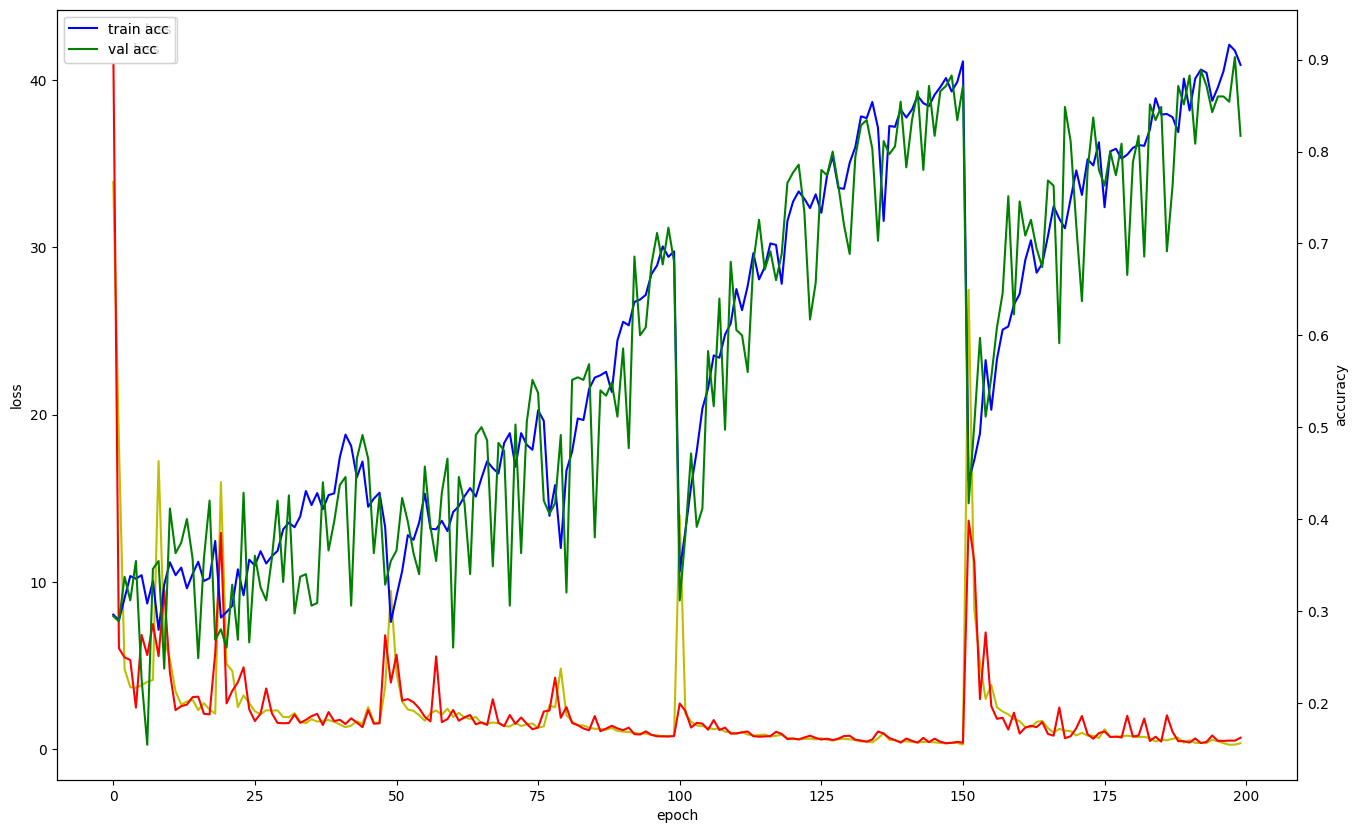

In [40]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [41]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

11/11 [==============================] - 3s 5ms/step


array([[[283,   3],
        [  9,  55]],

       [[262,  12],
        [  2,  74]],

       [[237,   8],
        [ 15,  90]],

       [[234,  11],
        [  8,  97]]], dtype=int64)

In [43]:
model.evaluate(x_val, y_val)

11/11 [==============================] - 0s 4ms/step - loss: 0.4950 - acc: 0.9029


[0.49495723843574524, 0.9028571248054504]